# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [58]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_mdn_seperate_posteriors_setx_short'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_mdn_seperate_posteriors_setx_short


In [59]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [60]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [61]:
prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [62]:
samples_prior_list = samples_prior.unsqueeze(0)

In [63]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [64]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


In [65]:

thetas = thetas[0]

samples_prior.shape

torch.Size([10000, 15])

In [66]:
from sbi.analysis.sbc import check_sbc, run_sbc, get_nltp
from sbi.analysis.plot import sbc_rank_plot
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian

In [67]:
#thetas = torch.stack(([samples_prior[i] for i in range(len(samples_prior))]))
xs = samples_prior

In [68]:
xs.shape

torch.Size([10000, 15])

TypeError: object of type 'Combined' has no len()

In [74]:
print(posterior)

NotImplementedError: 

In [72]:
posterior_samples = posterior.sample((10,), x= thetas[0])

print(posterior_samples.shape)

TypeError: sample() got an unexpected keyword argument 'x'

In [71]:
# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 300
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_posterior_samples=num_posterior_samples)

Running 10000 sbc samples.:   0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: sample() got an unexpected keyword argument 'x'

In [51]:
check_stats = check_sbc(ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples)


print(f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}")

kolmogorov-smirnov p-values 
check_stats['ks_pvals'] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [52]:
print(f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}")
print(f"- c2st accuracies check_stats['c2st_dap'] = {check_stats['c2st_dap'].numpy()}")


c2st accuracies 
check_stats['c2st_ranks'] = [0.6062  0.5931  0.61335 0.61075 0.62415 0.59025 0.6008  0.5886  0.61025
 0.60925 0.62705 0.5897  0.568   0.5929  0.57755]
- c2st accuracies check_stats['c2st_dap'] = [0.5917  0.5938  0.60385 0.6177  0.61115 0.5955  0.6016  0.57995 0.5978
 0.59285 0.61795 0.5879  0.5666  0.58715 0.55615]


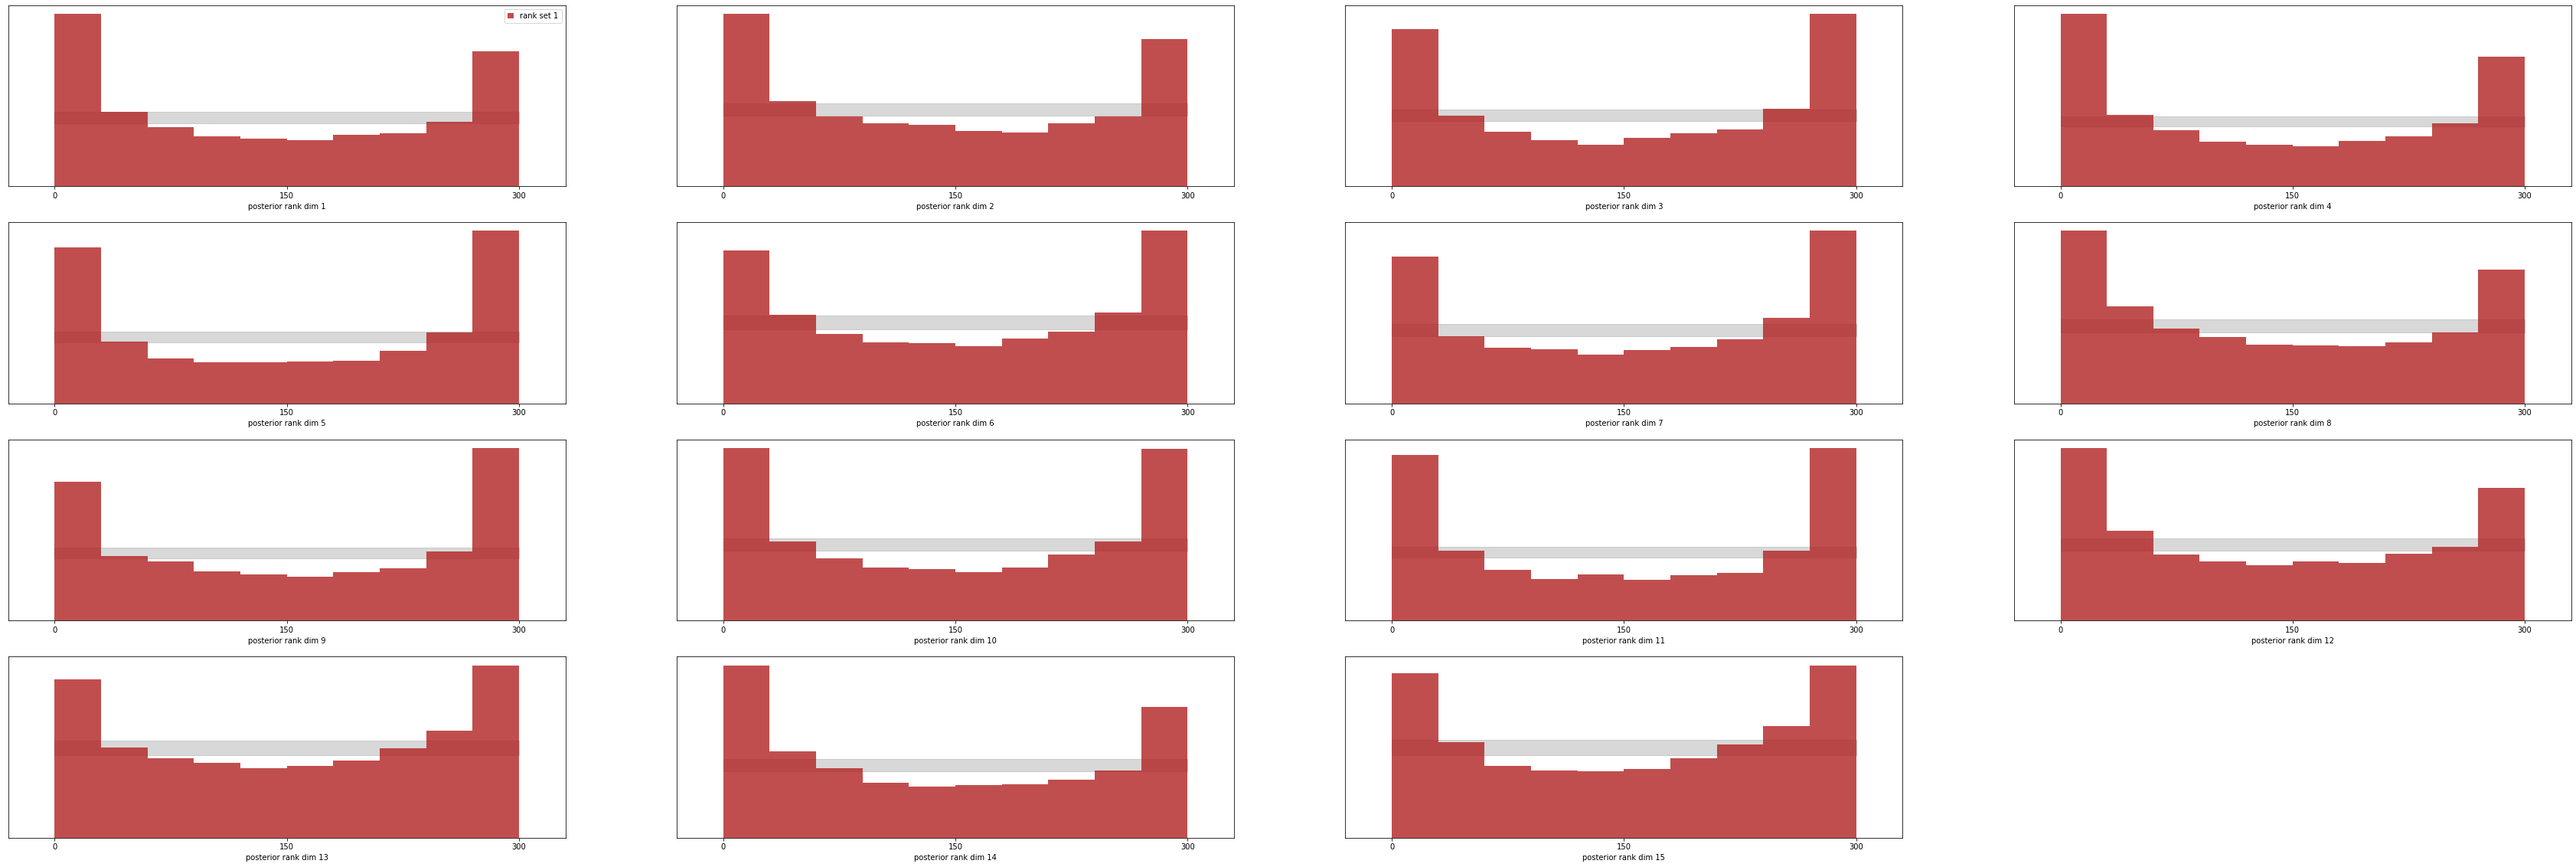

In [53]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks=ranks,
                      num_posterior_samples=num_posterior_samples,
                      plot_type="hist",
                      num_bins=10 # by passing None we use a heuristic for the number of bins.
                      )

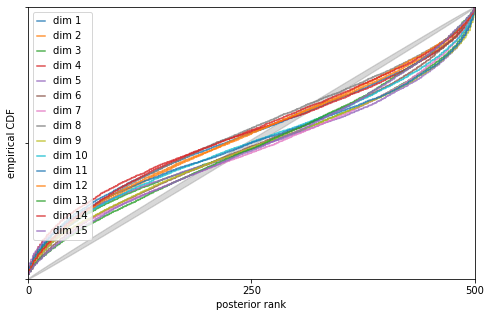

In [54]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "cdf")